In [1]:
import os
import librosa
import numpy as np
import pandas as pd
import torch
import torchaudio
from transformers import Wav2Vec2Processor, Wav2Vec2Model
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, confusion_matrix, classification_report
from scipy.stats import pearsonr
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns


c:\Users\kusha\OneDrive\Pictures\Desktop\shl assessment\project_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Paths
DATA_DIR = r"C:\Users\kusha\OneDrive\Pictures\Desktop\shl assessment"
TRAIN_CSV = os.path.join(DATA_DIR, "train.csv")
TEST_CSV = os.path.join(DATA_DIR, "test.csv")
TRAIN_AUDIO_DIR = os.path.join(DATA_DIR, "audio", "train")
TEST_AUDIO_DIR = os.path.join(DATA_DIR, "audio", "test")
SUBMISSION_FILE = os.path.join(DATA_DIR, "sample_submission.csv")


In [3]:
# Load metadata
train_df = pd.read_csv(TRAIN_CSV)
test_df = pd.read_csv(TEST_CSV)


In [4]:
# Load Wav2Vec2 model and processor
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h")
model.eval()


c:\Users\kusha\OneDrive\Pictures\Desktop\shl assessment\project_env\lib\site-packages\huggingface_hub\file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Wav2Vec2Model(
  (feature_extractor): Wav2Vec2FeatureEncoder(
    (conv_layers): ModuleList(
      (0): Wav2Vec2GroupNormConvLayer(
        (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
        (activation): GELUActivation()
        (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
      )
      (1): Wav2Vec2NoLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
        (activation): GELUActivation()
      )
      (2): Wav2Vec2NoLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
        (activation): GELUActivation()
      )
      (3): Wav2Vec2NoLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
        (activation): GELUActivation()
      )
      (4): Wav2Vec2NoLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
        (activation): GELUActivation()
      )
      (5): Wav2Vec2NoLay

In [5]:
# Feature extractor
def extract_features(file_path):
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        return None
    waveform, sr = librosa.load(file_path, sr=16000)
    input_values = processor(waveform, sampling_rate=16000, return_tensors="pt").input_values
    with torch.no_grad():
        features = model(input_values).last_hidden_state.mean(dim=1).squeeze().numpy()
    return features


In [6]:
# Filter classes with at least 2 samples
label_counts = train_df["label"].value_counts()
valid_labels = label_counts[label_counts >= 2].index
train_df = train_df[train_df["label"].isin(valid_labels)].reset_index(drop=True)



In [7]:
# Encode labels
train_df["full_path"] = train_df["filename"].apply(lambda x: os.path.join(TRAIN_AUDIO_DIR, x))
train_df = train_df[train_df["full_path"].apply(os.path.exists)].reset_index(drop=True)
label_encoder = LabelEncoder()
train_df["label_encoded"] = label_encoder.fit_transform(train_df["label"])


In [10]:
# Extract features
X_train, y_train = [], []
for _, row in tqdm(train_df.iterrows(), total=len(train_df)):
    features = extract_features(row["full_path"])
    if features is not None:
        X_train.append(features)
        y_train.append(row["label_encoded"])

X = np.array(X_train)
y = np.array(y_train)

0it [00:00, ?it/s]


In [55]:
# Balance dataset
df_features = pd.DataFrame(X)
df_features["label"] = y
max_class_size = df_features["label"].value_counts().max()
balanced_dfs = [resample(df_features[df_features["label"] == lbl], replace=True,
                         n_samples=max_class_size, random_state=42) for lbl in df_features["label"].unique()]
df_balanced = pd.concat(balanced_dfs)
X_bal = df_balanced.drop("label", axis=1).values
y_bal = df_balanced["label"].values

# Split dataset
X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(
    X_bal, y_bal, test_size=0.2, random_state=42, stratify=y_bal)


In [56]:
# Train classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_split, y_train_split)
y_pred = clf.predict(X_test_split)



In [57]:
# Evaluation
unique_test_labels = np.unique(y_test_split)
label_names = label_encoder.inverse_transform(unique_test_labels)
print(classification_report(y_test_split, y_pred, target_names=label_names.astype(str)))

              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        30
         1.5       1.00      1.00      1.00        30
         2.0       1.00      0.93      0.97        30
         2.5       0.94      1.00      0.97        30
         3.0       0.94      1.00      0.97        30
         3.5       0.97      1.00      0.98        30
         4.0       1.00      0.83      0.91        30
         4.5       0.87      0.90      0.89        30
         5.0       0.84      0.87      0.85        30

    accuracy                           0.95       270
   macro avg       0.95      0.95      0.95       270
weighted avg       0.95      0.95      0.95       270



In [58]:
# RMSE
rmse = np.sqrt(mean_squared_error(y_test_split, y_pred))
print(f"\nRMSE on validation set: {rmse:.4f}")



RMSE on validation set: 0.5900


In [59]:
# Pearson Correlation
pearson_corr, _ = pearsonr(y_test_split, y_pred)
print(f"Pearson Correlation on validation set: {pearson_corr:.4f}")



Pearson Correlation on validation set: 0.9739


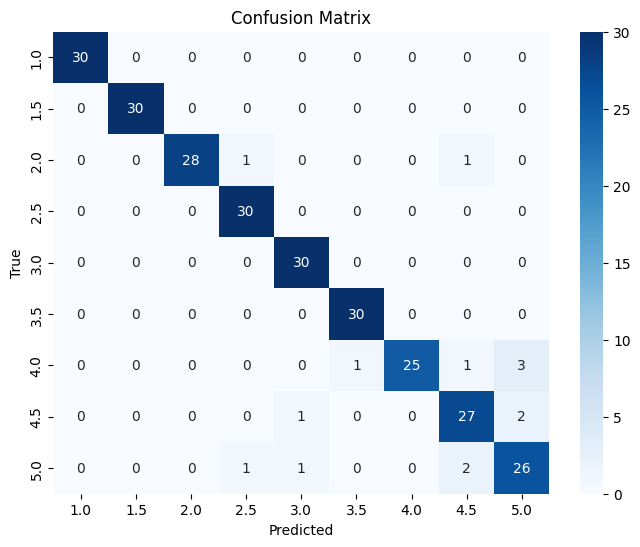

In [60]:
# Confusion Matrix
cm = confusion_matrix(y_test_split, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_names, yticklabels=label_names, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

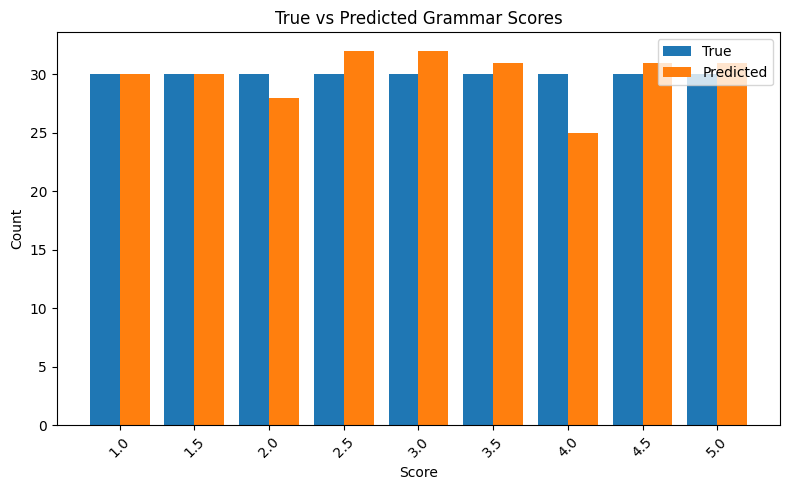

In [68]:
# Histogram
plt.figure(figsize=(8,5))
plt.hist([y_test_split, y_pred], bins=np.arange(0, len(label_names)+1)-0.5, 
         label=['True', 'Predicted'], rwidth=0.8)
plt.xticks(np.arange(len(label_names)), label_names, rotation=45)
plt.legend()
plt.title('True vs Predicted Grammar Scores')
plt.xlabel('Score')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


In [62]:
# --- FINAL TEST PREDICTION ---
test_df["full_path"] = test_df["filename"].apply(lambda x: os.path.join(TEST_AUDIO_DIR, x))
X_test_final = []
for path in tqdm(test_df["full_path"], desc="Extracting test features"):
    feat = extract_features(path)
    if feat is not None:
        X_test_final.append(feat)
X_test_final = np.array(X_test_final)


Extracting test features: 100%|██████████| 204/204 [1:51:34<00:00, 32.82s/it]  


In [65]:
# Predict
test_preds = clf.predict(X_test_final)
decoded_preds = label_encoder.inverse_transform(test_preds)


In [67]:
# Create submission
submission_df = pd.read_csv(SUBMISSION_FILE)
submission_df["label"] = decoded_preds
submission_df.to_csv("submission.csv", index=False)
print("submission.csv created!")

submission.csv created!
